1. KMeans Clustering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, silhouette_score

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge data on CustomerID
data = pd.merge(customers, transactions, on='CustomerID')

# Feature Engineering
data['TransactionFrequency'] = data.groupby('CustomerID')['TransactionID'].transform('count')
data['TotalSpent'] = data.groupby('CustomerID')['TotalValue'].transform('sum')
data['AverageTransactionValue'] = data['TotalSpent'] / data['TransactionFrequency']
data['Recency'] = (pd.to_datetime('today') - pd.to_datetime(data['TransactionDate'])).dt.days

cluster_data = data.groupby('CustomerID').agg({
    'TransactionFrequency': 'first',
    'TotalSpent': 'first',
    'AverageTransactionValue': 'first',
    'Recency': 'first',
    'Region': 'first'
}).reset_index()

# Encode categorical features
cluster_data = pd.get_dummies(cluster_data, columns=['Region'], drop_first=True)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_data.drop('CustomerID', axis=1))

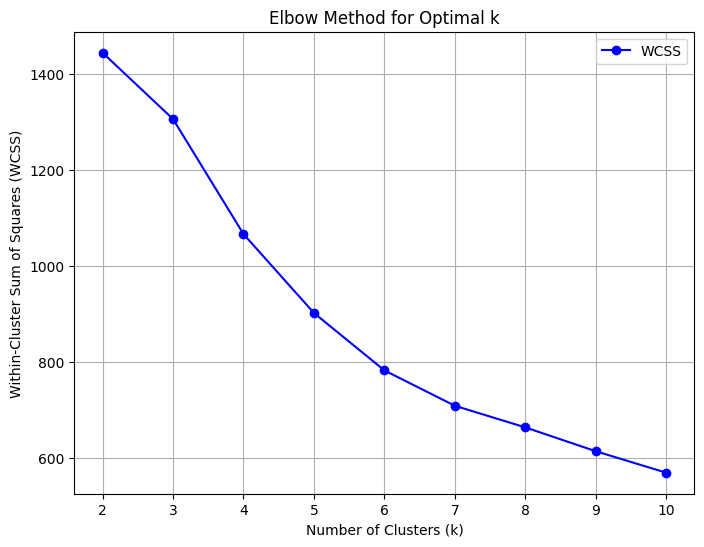

In [30]:
# Finding optimal number of clusters using the Elbow Method
wcss = []
k_values = range(2, 11) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b', label='WCSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

In [3]:
# Choosing the optimal k based on the elbow point
optimal_k = 10

# Perform clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
cluster_data['Cluster'] = clusters

# Evaluation Metrics
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette = silhouette_score(scaled_features, clusters)
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

DB Index: 1.185698423597557
Silhouette Score: 0.2784484866922561


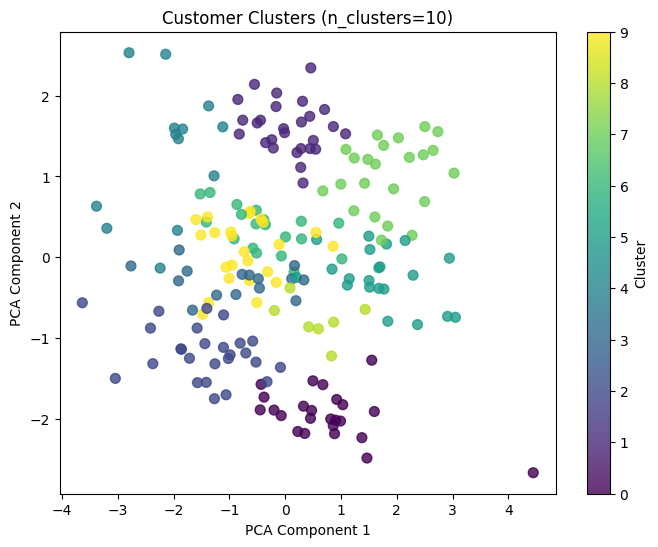

In [4]:
# Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.8)
plt.title(f'Customer Clusters (n_clusters={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

2. Hierarchial Clustering

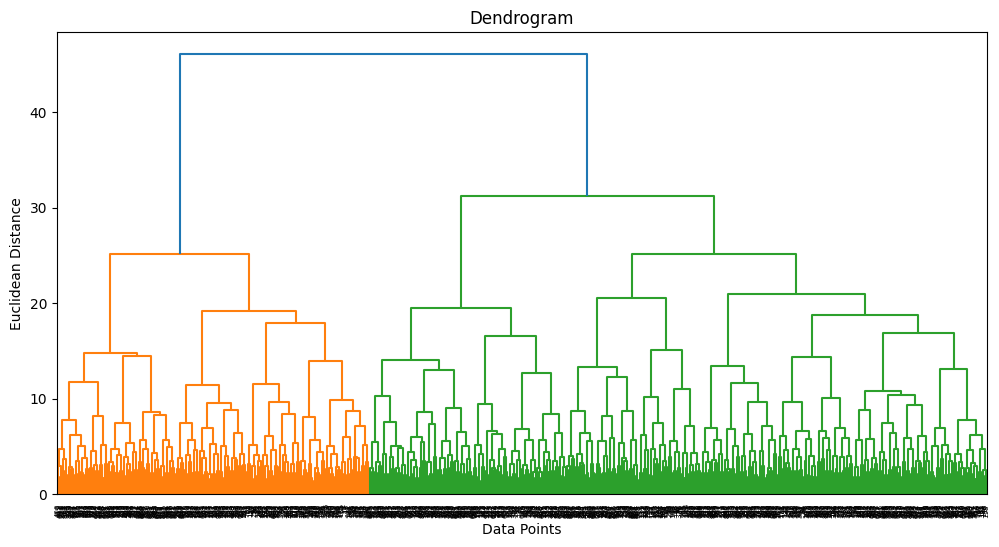

Davies-Bouldin Index: 2.595254977572607
Silhouette Score: 0.05128312498191942


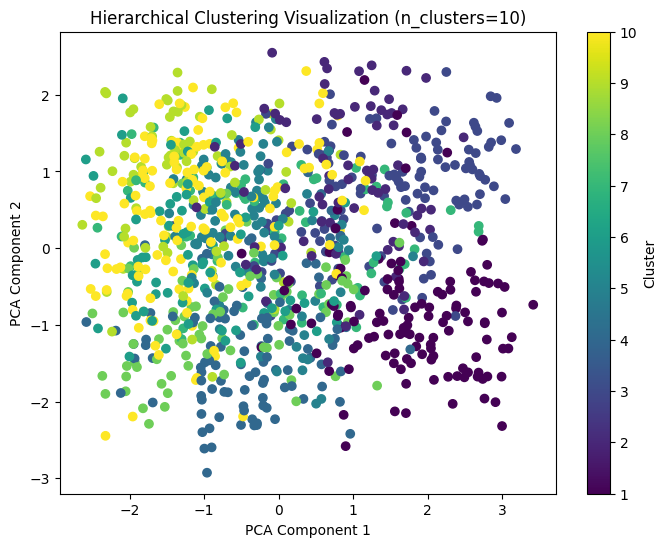

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge data on CustomerID
data = pd.merge(customers, transactions, on='CustomerID')

string_columns = data.select_dtypes(include=[object]).columns.tolist()

for col in string_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# 1. Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 2. Perform hierarchical clustering using linkage
linkage_matrix = linkage(scaled_data, method='ward')  # You can try 'average' or 'complete'

# 3. Visualize the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title("Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

# 4. Decide on the number of clusters and cut the dendrogram
num_clusters = 10
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# 5. Add cluster labels to the data
data['Cluster'] = clusters

# 6. Evaluate clustering with DB Index and Silhouette Score
db_index = davies_bouldin_score(scaled_data, clusters)
silhouette_avg = silhouette_score(scaled_data, clusters)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# 7. Visualize clusters (using PCA for dimensionality reduction)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label="Cluster")
plt.title(f"Hierarchical Clustering Visualization (n_clusters={num_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
